In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from statistics_kit import *

import serial
import time

# Set up the serial connection
ser = serial.Serial('/dev/ttyACM0', 115200)  # Adjust the baud rate if necessary
time.sleep(.1)  # Wait for the connection to establish


def ask(cmd,**kwargs):
    # function waits for an answer, since readline is blocking 
    ser.reset_input_buffer()
    ser.write(f"{cmd}\n".encode())  # Send the number followed by a newline
    #time.sleep(.001)  # Wait for a second before sending the next number
    line = ser.readline().decode()
    line = line.replace("\r","")
    line = line.replace("\n","")
    #print("readback: ",end="")
    return line


# initial calibration constants of the ADC
m = 4096
y0 = 0


def read_adc(**kwargs):
    ch = kwargs.get("ch",0)
    ans = ask("ADC={:d}".format(ch))
    return int(ans)

def r_fpga_reg(n):
    cmd="FPGA=01{:02x}{:04x}".format(n,0);
    ans = ask(cmd)
    return int(ans[4:],16)

def w_fpga_reg(n,val):
    cmd="FPGA=02{:02x}{:04x}".format(n,val);
    return ask(cmd)

def w_fpga_reg_bit(n,b,state):
    cur_val = r_fpga_reg(n)
    new_val = (cur_val & ~(1<<b)) | (state*(1<<b))
    w_fpga_reg(n, new_val)
    
def set_loop_length(n):
    w_fpga_reg(2, n)
    
def get_loop_length():
    return r_fpga_reg(2)
    
def enable_stop(state):
    w_fpga_reg_bit(3,0,state)
    
def enable_start(state):
    w_fpga_reg_bit(3,2,state)
    
def enable_trig(state):
    w_fpga_reg_bit(3,3,state)
    
def enable_mask(state):
    w_fpga_reg_bit(3,1,state)
    
def set_thr_start(val):
    w_fpga_reg(0,int(val))
    
def set_thr_stop(val):
    w_fpga_reg(1,int(val))
    
def set_mask_time(val):
    w_fpga_reg(4,int(val))
    
def set_trig_time(val):
    w_fpga_reg(7,int(val))
    
def get_trig_time():
    return r_fpga_reg(7)
    
def set_start_time(val):
    w_fpga_reg(5,int(val))
    
def set_stop_time(val):
    w_fpga_reg(6,int(val))
    
def read_calib_adc():
    return (read_adc(ch=0)-y0)/m

def set_pulse_ns_arduino(start_time_ns,width_ns,loop_length):
    return ask("set_pulse_ns={},{},{}".format(start_time_ns,width_ns,loop_length))
    
#ser.close()

print(read_adc())
print(get_loop_length())

509
10


In [102]:
read_adc()

434

In [177]:
# Set up the serial connection
ser2 = serial.Serial('/dev/ttyACM1', 115200)  # Adjust the baud rate if necessary
time.sleep(.1)  # Wait for the connection to establish


def ask2(cmd,**kwargs):
    # function waits for an answer, since readline is blocking 
    ser2.reset_input_buffer()
    ser2.write(f"{cmd}\n".encode())  # Send the number followed by a newline
    #time.sleep(.001)  # Wait for a second before sending the next number
    line = ser2.readline().decode()
    line = line.replace("\r","")
    line = line.replace("\n","")
    #print("readback: ",end="")
    return line[4:]

In [217]:
def pop_count(data):
    out = []
    for xstr in data:
        out += [len("{:0128b}".format(int(xstr,16)).replace("0",""))]
    return np.sum(out)

In [170]:
def r_fpga_reg2(n):
    cmd="01{:02x}{:032x}".format(n,0);
    ans = ask2(cmd)
    return int(ans[4:],16)

In [392]:
#ask2("020012341234123412341234123412341234")
ask2("0200"+32*"4")
ask2("010000000")

'44444444444444444444444444444444'

In [422]:
qhex = ask2("0101")
pop_count(qhex)
print(qhex)

FFFFFFFFFFFFFF400000000000000000


In [510]:
#set_pulse_ns_arduino(11.7,20,20)
set_pulse_ns_arduino(12.1,20,20)

'1'

8.080198017375565
67.82


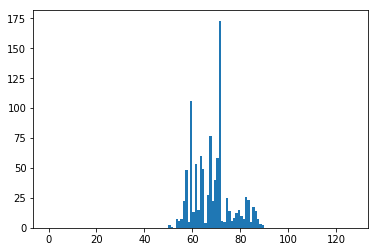

In [482]:
n=1000

set_pulse_ns_arduino(11.9,20,200)

tdc_pop = np.array([])

for i in range(n):
    
    qhex = ask2("0101")
    tdc_pop = np.append(tdc_pop, [pop_count(qhex)])
    
plt.hist(tdc_pop,bins=np.arange(0,128,1))
print(np.std(tdc_pop))
print(np.mean(tdc_pop))

In [509]:
# LE scan and read TDC


x = np.array([])
avg_pop = np.array([])
std_pop = np.array([])

n=50

for t in np.arange(11.5,12.5,0.05):
    set_pulse_ns_arduino(t,20,20)
    
    tdc_pop = np.array([])
    for i in range(n):
        qhex = ask2("0101")
        tdc_pop = np.append(tdc_pop, [pop_count(qhex)])
    avg_pop = np.append(avg_pop,[np.mean(tdc_pop)])
    std_pop = np.append(std_pop,[np.std(tdc_pop)])
        
    x = np.append(x,[t])

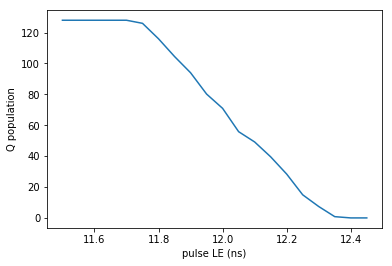

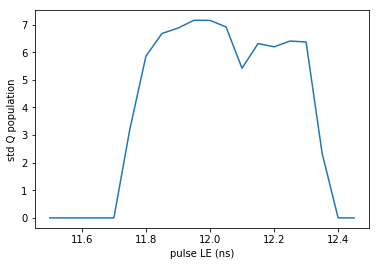

In [494]:
plt.plot(x,avg_pop)
plt.xlabel("pulse LE (ns)")
plt.ylabel("Q population")
plt.show()
plt.plot(x,std_pop)
plt.xlabel("pulse LE (ns)")
plt.ylabel("std Q population")
plt.show()

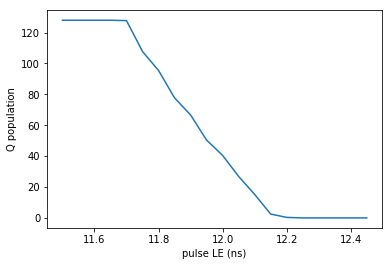

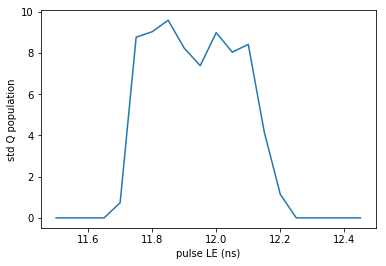

In [461]:
plt.plot(x,avg_pop)
plt.xlabel("pulse LE (ns)")
plt.ylabel("Q population")
plt.show()
plt.plot(x,std_pop)
plt.xlabel("pulse LE (ns)")
plt.ylabel("std Q population")
plt.show()

In [29]:
ser2.close()

In [26]:
# sweep for CC TDC

set_trig_time(2)

# LE sweep
#for i in np.arange(5,15,2):
for i in np.arange(11.6,12.2,0.1):
    set_pulse_ns_arduino(i,20,20)
    time.sleep(.5)

In [433]:

set_trig_time(2)
set_pulse_ns_arduino(12.0,20,20)

'1'

In [12]:
# LE sweep
for i in range(20):
    set_pulse_ns_arduino(i,5,20)


In [15]:
# combi sweep
for i in range(30):
    set_pulse_ns_arduino(i/2.,i,20)


In [513]:
##################################################
##          call the arduino function           ##
##################################################


from ipywidgets import interact

enable_trig(1)

def my_function(start_time_ns=0,width_ns=5,loop_length=20):
    
    #set_pulse_ns(start_time_ns,width_ns,loop_length)
    ask("set_pulse_ns={},{},{}".format(start_time_ns,width_ns,loop_length))

    
# create a slider
interact(my_function, 
         start_time_ns=(0,50,0.2),
         width_ns=(0,200,0.1),
         loop_length=(5,255,1)
        )


interactive(children=(FloatSlider(value=0.0, description='start_time_ns', max=50.0, step=0.2), FloatSlider(val…

<function __main__.my_function(start_time_ns=0, width_ns=5, loop_length=20)>

In [10]:
ser.close()